In [1]:
import pandas as pd
from neuralforecast.models import VanillaTransformer, Informer, Autoformer, PatchTST,FEDformer
from neuralforecast.core import NeuralForecast
import matplotlib.pyplot as plt
from neuralforecast.losses.numpy import mae, rmse, mse

d:\anaconda\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
df = pd.read_csv('data/Google_Stock_Price_Train.csv')
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
#neuralforecast的数据集必须格式 ds y unique_id
df['unique_id'] = 1
df['ds'] = pd.to_datetime(df['ds'])
df["y"]=df["y"].apply(lambda x:float(x.replace(",",'')))
df["Volume"]=df["Volume"].apply(lambda x:float(x.replace(",",'')))

In [3]:
horizon=96
input_size=2*horizon
train_steps=20
check_steps=50
models = [VanillaTransformer(h=horizon,
                             input_size=input_size,
                             max_steps=train_steps,
                             val_check_steps=check_steps,
                             early_stop_patience_steps=3,
                             scaler_type='standard'),
          Informer(h=horizon,  # Forecasting horizon
                   input_size=input_size,  # Input size
                   max_steps=train_steps,  # Number of training iterations
                   val_check_steps=check_steps,  # Compute validation loss every 100 steps
                   early_stop_patience_steps=3,  # Number of validation iterations before early stopping
                   scaler_type='standard'),  # Stop training if validation loss does not improve
          Autoformer(h=horizon,
                     input_size=input_size,
                     max_steps=train_steps,
                     val_check_steps=check_steps,
                     early_stop_patience_steps=3),
          PatchTST(h=horizon,
                   input_size=input_size,
                   max_steps=train_steps,
                   val_check_steps=check_steps,
                   early_stop_patience_steps=3),
          ]

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


In [4]:
fedmodel=[FEDformer(h=horizon,
                     input_size=input_size,
                     max_steps=train_steps,
                     val_check_steps=check_steps,
                     early_stop_patience_steps=3)]


Global seed set to 1


In [5]:
nf2=NeuralForecast(
    models=fedmodel,
    freq='D')

In [6]:
yp = nf2.cross_validation(df=df,
                               val_size=100,
                               test_size=100,
                               n_windows=None)

d:\anaconda\Lib\site-packages\neuralforecast\common\_base_model.py:346: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MAE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 384   
5 | dec_embedding | DataEmbedding | 384   
6 | encoder       | Encoder       | 279 K 
7 | decoder       | Decoder       | 403 K 
------------------------------------------------
683 K     Trainable params
0         Non-trainable params
683 K     Total params
2.735     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

d:\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\anaconda\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you wa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=20` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

d:\anaconda\Lib\site-packages\neuralforecast\core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


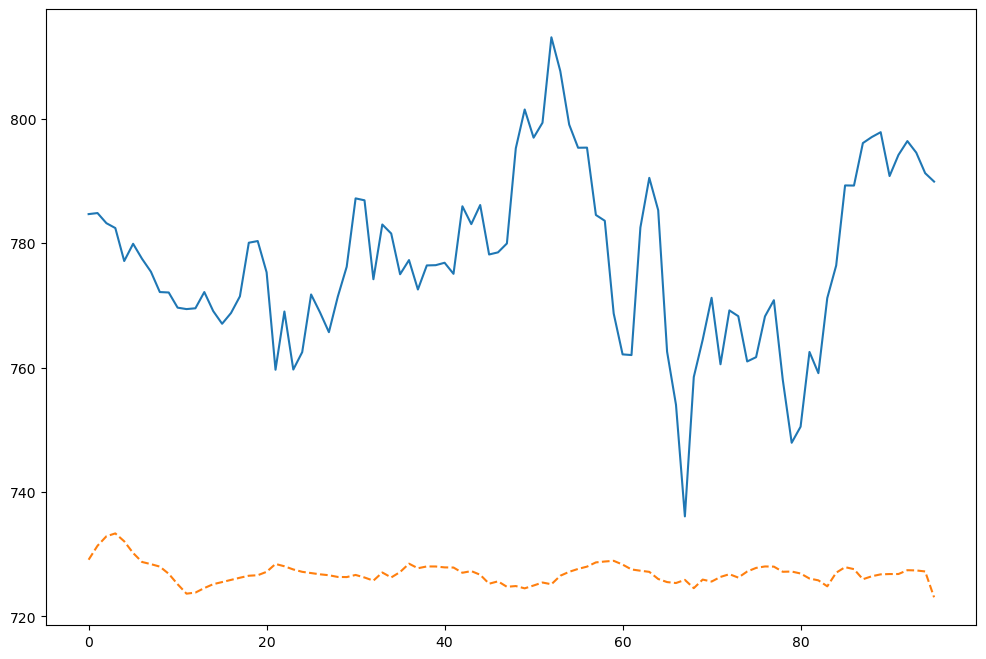

In [8]:
y_true = yp['y'].values
y_pred_FEDformer = yp['FEDformer'].values
n_series = len(df['unique_id'].unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_pred_FEDformer = y_pred_FEDformer.reshape(n_series, -1, horizon)

fig, ax = plt.subplots(figsize=(12,8))
 
ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_FEDformer[0, 0, :], label='FEDformer', ls='--')

In [9]:
rmse(yp["FEDformer"],yp["y"])

51.46927193848636

In [ ]:
nf = NeuralForecast(
    models=models,
    freq='B')
 
 
Y_hat_df = nf.cross_validation(df=df,
                               val_size=100,
                               test_size=100,
                               n_windows=None)

In [10]:
y_true = Y_hat_df['y'].values
y_pred_VanillaTransformer = Y_hat_df['VanillaTransformer'].values
y_pred_Informer = Y_hat_df['Informer'].values
y_pred_Autoformer = Y_hat_df['Autoformer'].values
y_pred_patchtst = Y_hat_df['PatchTST'].values
 
n_series = len(df['unique_id'].unique())
 
y_true = y_true.reshape(n_series, -1, horizon)
y_pred_VanillaTransformer = y_pred_VanillaTransformer.reshape(n_series, -1, horizon)
y_pred_Informer = y_pred_Informer.reshape(n_series, -1, horizon)
y_pred_Autoformer = y_pred_Autoformer.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

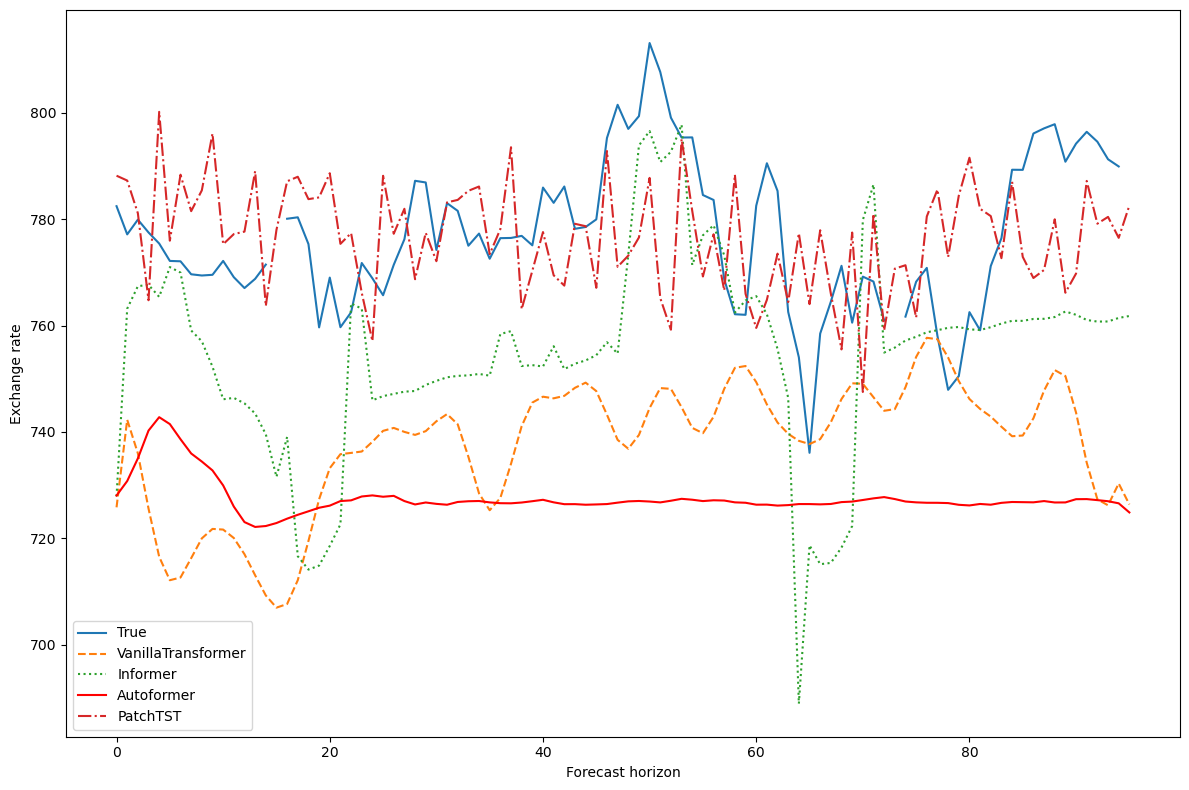

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
 
ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_VanillaTransformer[0, 0, :], label='VanillaTransformer', ls='--')
ax.plot(y_pred_Informer[0, 0, :], label='Informer', ls=':')
ax.plot(y_pred_Autoformer[0, 0, :], label='Autoformer', c="r")
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Exchange rate')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')
 
plt.tight_layout()

In [16]:
rmse(Y_hat_df["VanillaTransformer"],Y_hat_df["y"])

40.53601710188521

In [17]:
rmse(Y_hat_df["Informer"],Y_hat_df["y"])

29.206564657593134

In [18]:
rmse(Y_hat_df["Autoformer"],Y_hat_df["y"])

50.86642681298287

In [19]:
rmse(Y_hat_df["PatchTST"],Y_hat_df["y"])

16.150931290063433